In [1]:
import pandas as pd
import pandas_datareader.data as web
import datetime as dt
import bs4 as bs
import requests
import pickle

In [2]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
finwiz_url = 'https://finviz.com/quote.ashx?t='

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/otar/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [4]:
#len(nasd)

In [5]:
with open("nasdaqtickers.pickle", "rb") as f:
        tickers = pickle.load( f)

In [6]:
#tickers

In [510]:
%%time
news_tables = {}
#tickers = ['AMZN', 'TSLA', 'GOOG', 'AAPL']

for ticker in tickers:
    url = finwiz_url + ticker
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
    response = urlopen(req)    
    # Read the contents of the file into 'html'
    html = BeautifulSoup(response)
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    # Add the table to our dictionary
    news_tables[ticker] = news_table

CPU times: user 1min 9s, sys: 2.02 s, total: 1min 11s
Wall time: 1min 41s


In [511]:
# Read one single day of headlines for 'AMZN' 
amzn = news_tables['AAPL']
# Get all the table rows tagged in HTML with <tr> into 'amzn_tr'
amzn_tr = amzn.findAll('tr')

for i, table_row in enumerate(amzn_tr):
    # Read the text of the element 'a' into 'link_text'
    a_text = table_row.a.text
    # Read the text of the element 'td' into 'data_text'
    td_text = table_row.td.text
    # Print the contents of 'link_text' and 'data_text' 
    print(a_text)
    print(td_text)
    # Exit after printing 4 rows of data
    if i == 3:
        break

PlayStation 5 Scalpers Use Bots to Hunt Down Scarce Consoles
Dec-17-20 02:25AM  
Apple's Retort To Facebook After Full-Page Ads: New Policy 'Simply Requires They Give Users A Choice'
Dec-16-20 11:10PM  
Apple Fitness+ Riding On Halo Effect Will Leave Peloton Trailing In Subscriptions, Munster Says
09:38PM  
Facebook Attacks Apple Software Changes in Newspaper Ads
07:01PM  


In [512]:
parsed_news = []

# Iterate through the news
for file_name, news_table in news_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # read the text from each tr tag into text
        # get text from a only
        text = x.a.get_text() 
        # splite text in the td tag into a list 
        date_scrape = x.td.text.split()
        # if the length of 'date_scrape' is 1, load 'time' as the only element

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        # else load 'date' as the 1st element and 'time' as the second    
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split('_')[0]
        
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, text])
        
parsed_news[0:4]

[['ATVI',
  'Dec-16-20',
  '03:00PM',
  'Twitter Taps Activision Blizzard and Grammys Alum Beverly Jackson as Head of Consumer Marketing'],
 ['ATVI',
  'Dec-15-20',
  '04:16PM',
  'Electronic Arts (EA) to Outspend Take Two for Codemasters'],
 ['ATVI',
  'Dec-14-20',
  '02:48PM',
  "Is Netflix in Trouble for Hiring Activision Blizzard's CFO?"],
 ['ATVI',
  'Dec-12-20',
  '07:30AM',
  'Successful Investors: What Would You Do in 2021 With a Blank Slate and $5,000?']]

In [513]:
%%time
# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# Set column names
columns = ['ticker', 'date', 'time', 'headline']

# Convert the parsed_news list into a DataFrame called 'parsed_and_scored_news'
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)
#print(parsed_and_scored_news.head())
# Iterate through the headlines and get the polarity scores using vader
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the news and the list of dicts
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')

# Convert the date column from string to datetime
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date

parsed_and_scored_news.head(5)

CPU times: user 1.58 s, sys: 30.8 ms, total: 1.61 s
Wall time: 1.89 s


,ticker,date,time,headline,neg,neu,pos,compound
0,ATVI,2020-12-16,03:00PM,Twitter Taps Activision Blizzard and Grammys A...,0.000,1.000,0.000,0.0000
1,ATVI,2020-12-15,04:16PM,Electronic Arts (EA) to Outspend Take Two for ...,0.000,1.000,0.000,0.0000
2,ATVI,2020-12-14,02:48PM,Is Netflix in Trouble for Hiring Activision Bl...,0.252,0.748,0.000,-0.4019
3,ATVI,2020-12-12,07:30AM,Successful Investors: What Would You Do in 202...,0.000,0.759,0.241,0.5859
4,ATVI,2020-12-12,01:25AM,"Activision Blizzard, Inc.'s (NASDAQ:ATVI) Intr...",0.000,0.705,0.295,0.5574


In [514]:
parsed_and_scored_news.shape

(10299, 8)

In [515]:
parsed_and_scored_news[parsed_and_scored_news.ticker=='AAPL']

,ticker,date,time,headline,neg,neu,pos,compound
1100,AAPL,2020-12-17,02:25AM,PlayStation 5 Scalpers Use Bots to Hunt Down S...,0.000,1.000,0.000,0.0000
1101,AAPL,2020-12-16,11:10PM,Apple's Retort To Facebook After Full-Page Ads...,0.000,1.000,0.000,0.0000
1102,AAPL,2020-12-16,09:38PM,Apple Fitness+ Riding On Halo Effect Will Leav...,0.085,0.915,0.000,-0.0516
1103,AAPL,2020-12-16,07:01PM,Facebook Attacks Apple Software Changes in New...,0.293,0.707,0.000,-0.4404
1104,AAPL,2020-12-16,06:31PM,Daily Crunch: Facebook escalates Apple criticism,0.367,0.633,0.000,-0.4404
...,...,...,...,...,...,...,...,...
1195,AAPL,2020-12-14,11:37AM,TikTok Appellate Judges Signal Skepticism of T...,0.412,0.588,0.000,-0.6808
1196,AAPL,2020-12-14,10:54AM,Apple series 6 vs Apple SE: Which smartwatch i...,0.000,0.656,0.344,0.6369
1197,AAPL,2020-12-14,10:30AM,Facebook Investors Don't Need to Fear a Breakup,0.000,0.695,0.305,0.3875
1198,AAPL,2020-12-14,10:23AM,Tesla Stock Is Rising Ahead of Inclusion in th...,0.000,1.000,0.000,0.0000


In [516]:
with open("171220_nasdaq.pickle", "wb") as f:
    pickle.dump(parsed_and_scored_news, f)

# Example

In [517]:
with open("news_nasdaq.pickle", "rb") as f:
        df_1 = pickle.load(f)

with open("171220_nasdaq.pickle", "rb") as f:
        df_2 = pickle.load(f)

In [518]:
df_news = df_1.append(df_2, ignore_index=True, sort=False)
#df_news = pd.concat([df_1,df_2])
#df_news[df_news.ticker=='AAPL'].head()
df_news = df_news.drop_duplicates()
df_news.shape, df_1.shape, df_2.shape

((26118, 8), (25718, 8), (10299, 8))

In [519]:
print(len(df_news)-len(df_1), 'new articles added !')

400 new articles added !


In [520]:
df_1[df_1.ticker=='AAPL'].head(5)

,ticker,date,time,headline,neg,neu,pos,compound
1098,AAPL,2020-10-26,12:49PM,Best Buy CEO Corie Barry: The COVID-19 pandemi...,0.00,0.608,0.392,0.7964
1099,AAPL,2020-10-26,12:46PM,Best Buy CEO Corie Barry: We are doing everyth...,0.12,0.652,0.228,0.4588
1100,AAPL,2020-10-26,12:45PM,Apple Might Skip Holiday-Quarter Guidance With...,0.00,1.000,0.000,0.0000
1101,AAPL,2020-10-26,12:30PM,Dow Jones Plunges 700 Points as Cases of Coron...,0.00,1.000,0.000,0.0000
1102,AAPL,2020-10-26,12:18PM,Comcast (CMCSA) to Report Q3 Earnings: What's ...,0.00,1.000,0.000,0.0000


In [521]:
df_2[df_2.ticker=='AAPL'].head()

,ticker,date,time,headline,neg,neu,pos,compound
1100,AAPL,2020-12-17,02:25AM,PlayStation 5 Scalpers Use Bots to Hunt Down S...,0.000,1.000,0.0,0.0000
1101,AAPL,2020-12-16,11:10PM,Apple's Retort To Facebook After Full-Page Ads...,0.000,1.000,0.0,0.0000
1102,AAPL,2020-12-16,09:38PM,Apple Fitness+ Riding On Halo Effect Will Leav...,0.085,0.915,0.0,-0.0516
1103,AAPL,2020-12-16,07:01PM,Facebook Attacks Apple Software Changes in New...,0.293,0.707,0.0,-0.4404
1104,AAPL,2020-12-16,06:31PM,Daily Crunch: Facebook escalates Apple criticism,0.367,0.633,0.0,-0.4404


In [522]:
#df_news[(df_news.ticker=='ATVI') | (df_news.date==dt.datetime(2020,10,28))]

In [523]:
with open("news_nasdaq.pickle", "wb") as f:
    pickle.dump(df_news, f)

In [524]:
df_news[df_news.headline.str.contains('Surprise', case=False, regex=True)].shape

(109, 8)

In [525]:
df_test = df_news[(df_news.ticker=='TSLA') | (df_news.ticker=='AAPL')]
df_test.head()

,ticker,date,time,headline,neg,neu,pos,compound
1098,AAPL,2020-10-26,12:49PM,Best Buy CEO Corie Barry: The COVID-19 pandemi...,0.00,0.608,0.392,0.7964
1099,AAPL,2020-10-26,12:46PM,Best Buy CEO Corie Barry: We are doing everyth...,0.12,0.652,0.228,0.4588
1100,AAPL,2020-10-26,12:45PM,Apple Might Skip Holiday-Quarter Guidance With...,0.00,1.000,0.000,0.0000
1101,AAPL,2020-10-26,12:30PM,Dow Jones Plunges 700 Points as Cases of Coron...,0.00,1.000,0.000,0.0000
1102,AAPL,2020-10-26,12:18PM,Comcast (CMCSA) to Report Q3 Earnings: What's ...,0.00,1.000,0.000,0.0000


In [526]:
start = dt.datetime(2020,10,21)
end = dt.datetime(2020,11,20)

In [527]:
df = web.DataReader('AAPL','yahoo',start,end)

In [528]:
df_2 = web.DataReader('TSLA','yahoo',start,end)

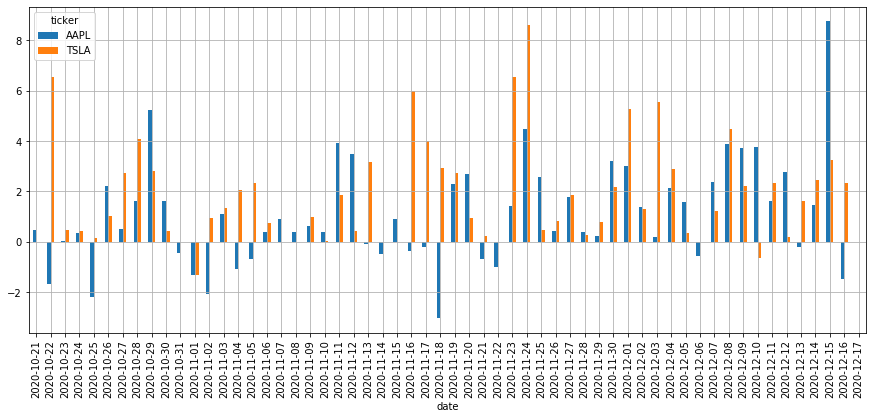

In [529]:
plt.rcParams['figure.figsize'] = [15, 6]


# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = df_test.groupby(['ticker','date']).sum()

# Unstack the column ticker
mean_scores = mean_scores.unstack()
#print(mean_scores.head())
# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()
#print(mean_scores.head())

# Plot a bar chart with pandas
mean_scores.plot(kind = 'bar')
plt.grid()

In [48]:
#mean_scores.head()

In [207]:
go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])

In [208]:
go.Figure(data=[go.Candlestick(x=df_2.index,
                open=df_2['Open'],
                high=df_2['High'],
                low=df_2['Low'],
                close=df_2['Close'])])

In [209]:
df_news.head()

,ticker,date,time,headline,neg,neu,pos,compound
0,ATVI,2020-10-26,12:49PM,Best Buy CEO Corie Barry: The COVID-19 pandemi...,0.00,0.608,0.392,0.7964
1,ATVI,2020-10-26,12:46PM,Best Buy CEO Corie Barry: We are doing everyth...,0.12,0.652,0.228,0.4588
2,ATVI,2020-10-26,11:03AM,Why Take-Two and Ubisoft Will Continue to Outp...,0.00,1.000,0.000,0.0000
3,ATVI,2020-10-26,09:46AM,Factors Setting the Tone for Penn National (PE...,0.00,1.000,0.000,0.0000
4,ATVI,2020-10-26,09:42AM,Activision (ATVI) to Report Q3 Earnings: What'...,0.00,1.000,0.000,0.0000


In [634]:
df_news_aapl = df_news[(df_news['ticker']=='TSLA')]
df_news_aapl = df_news_aapl[(df_news_aapl['date']==dt.date(2020, 11, 18))]

In [635]:
#df_news_aapl['compound']

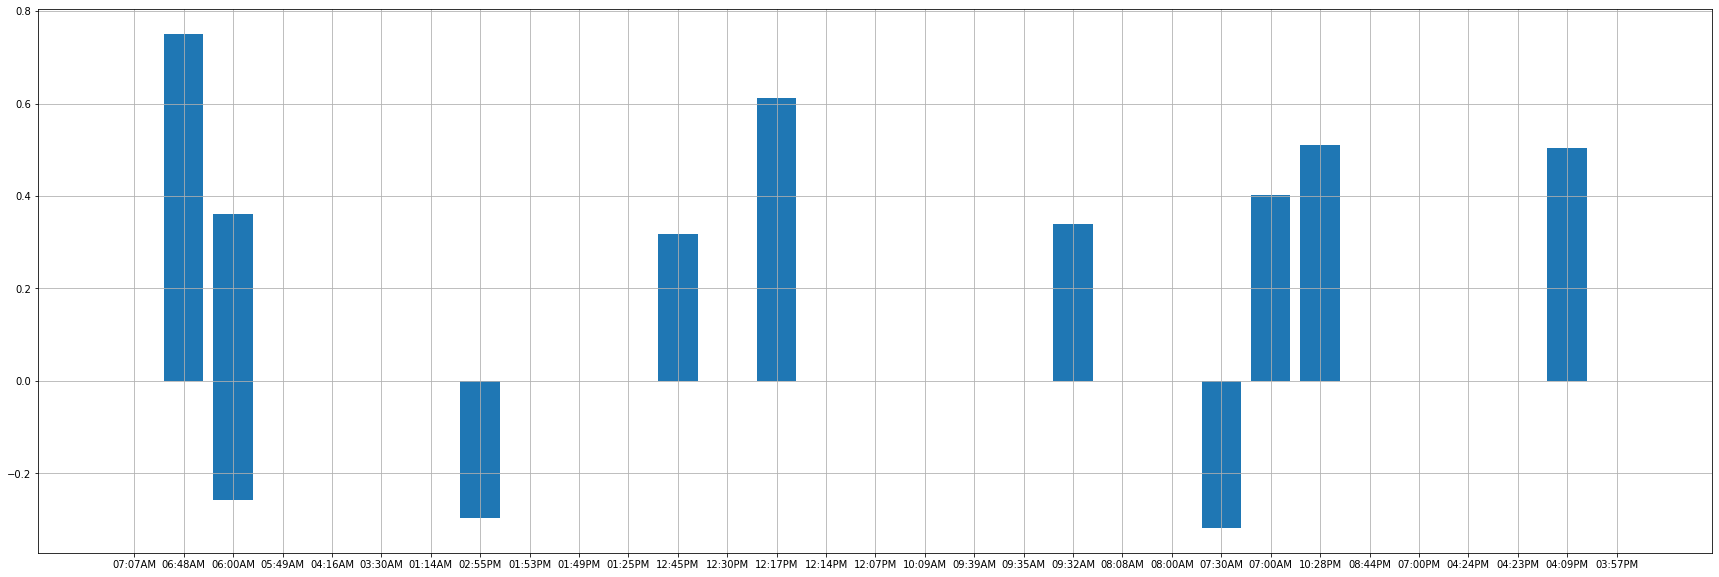

In [640]:
plt.figure(figsize=(30, 10))
plt.bar(df_news_aapl.time, df_news_aapl['compound'])
plt.grid()

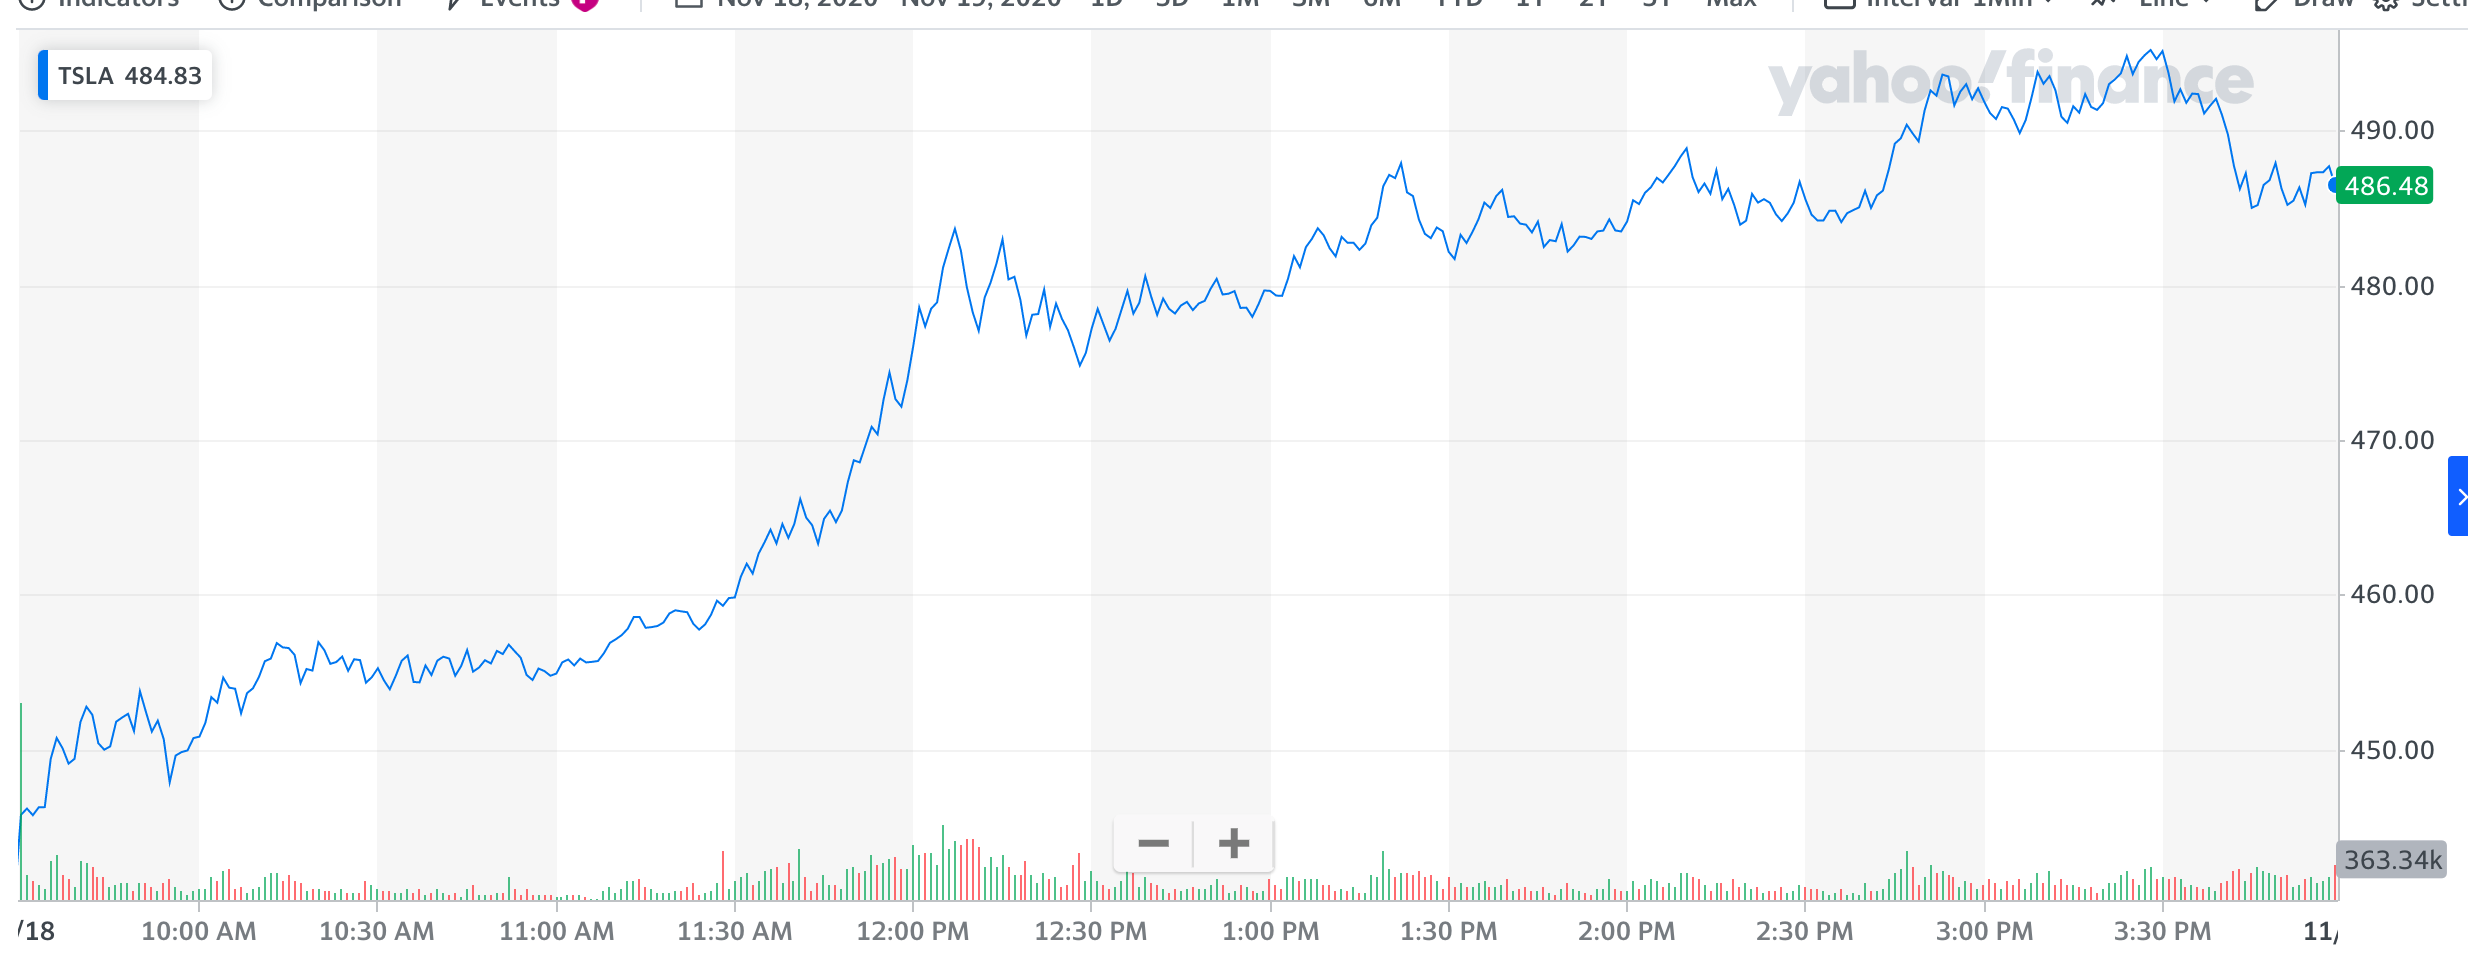

In [253]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-10-21,118.709999,116.449997,116.669998,116.870003,89946000,116.870003
2020-10-22,118.040001,114.589996,117.449997,115.750000,101988000,115.750000
2020-10-23,116.550003,114.279999,116.389999,115.040001,82572600,115.040001
2020-10-26,116.550003,112.879997,114.010002,115.050003,111850700,115.050003
2020-10-27,117.279999,114.540001,115.489998,116.599998,92276800,116.599998
